In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime, timedelta

# Load the data
ultra_marathon_loc = os.path.join(os.getcwd(), 'data', 'ultra_marathon.csv')
# ultra_marathon = pd.read_csv(ultra_marathon_loc, nrows=500000) # Reading 500k rows for faster testing
ultra_marathon = pd.read_csv(ultra_marathon_loc)
print("The .csv has been loaded.")



#_____________________________Clean the data_____________________________________


# Rename columns
ultra_marathon.rename(columns={
    'Year of event':                'Year',         # int
    'Event dates':                  'Dates',        # [datetime]
    'Event name':                   'Event_name',   # str
    'Event distance/length':        'Length',       # str; (km, mi or hours)
    'Event number of finishers':    'Finishers',    # int
    'Athlete performance':          'Performance',  # str; (km, mi or hours)
    'Athlete club':                 'Club',         # str
    'Athlete country':              'Country',      # str
    'Athlete year of birth':        'Birth',        # float
    'Athlete gender':               'Gender',       # int (M=0, F=1)
    'Athlete age category':         'Age',          # int
    'Athlete average speed':        'Average_speed',# float
    'Athlete ID':                   'Id'            # int
}, inplace=True)



# Drop entries with null values
# print(ultra_marathon.isnull().sum())
# ultra_marathon.dropna(subset=['Age', 'Birth'], inplace=True)


# Remove unnecesary information
ultra_marathon['Age'] = ultra_marathon['Age'].str.extract(r'(\d+)')
allowed_values = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']
ultra_marathon = ultra_marathon[ultra_marathon['Length'].isin(allowed_values)]
ultra_marathon = ultra_marathon[ultra_marathon['Gender'].notna() & (ultra_marathon['Gender'] != 'X')] # Eliminate the X and nan values
ultra_marathon['Gender'] = ultra_marathon['Gender'].map({'M': 0, 'F': 1}) # Encode gender to 0 and 1


# Parse into numeric data types
ultra_marathon['Year']          = pd.to_numeric(ultra_marathon['Year'], errors='coerce')
ultra_marathon['Finishers']     = pd.to_numeric(ultra_marathon['Finishers'], errors='coerce')
ultra_marathon['Birth']         = pd.to_numeric(ultra_marathon['Birth'], errors='coerce')
ultra_marathon['Age']           = pd.to_numeric(ultra_marathon['Age'], errors='coerce')
ultra_marathon['Average_speed'] = pd.to_numeric(ultra_marathon['Average_speed'], errors='coerce')
ultra_marathon['Id']            = pd.to_numeric(ultra_marathon['Id'], errors='coerce', downcast='integer')
# ultra_marathon.dropna(subset=['Year', 'Finishers', 'Birth', 'Age', 'Average_speed', 'Id'], inplace=True)


# Custom parsing (Currently disabled)

def parseDates(given_string):
    # The possible formats are: '00.01.2000', '01.-05.01.2000', '31.01.-01.02.2000', '31.12.2000-01.01.2001'
    try:
        return [datetime.strptime(given_string, "%d.%m.%Y")]
    except:
        pass
    try:
        interval = given_string.split('-')
        for separation_length in [3, 6, 10]:
            if len(interval[0]) == separation_length:
                first_day = datetime.strptime(interval[0] + interval[1][separation_length:], "%d.%m.%Y")
                last_day = datetime.strptime(interval[1], "%d.%m.%Y")
                # return [first_day + timedelta(days=i) for i in range((last_day - first_day).days + 1)]
                return [first_day, last_day]
    except:
        # None parsable & existent dates such as 00.01.2000
        return np.nan


# Returns (int value, int stages), where stage=0 indicates hours and any other stage indicates number of race stages
def parseLengths(given_string):
    if pd.isna(given_string):
        return (np.nan, np.nan)
    
    if "h" in given_string:
        try:
            return(float(re.search(r'(\d+)h', given_string)[1]), 0)
        except AttributeError:
            return (np.nan, np.nan)
    elif "d" in given_string:
        try:
            return(24 * float(re.search(r'(\d+)d', given_string)[1]), 0)
        except AttributeError:
            return (np.nan, np.nan)

    if "mi" in given_string:
        distance = round((1.60934 * float(re.search(r'(\d+(\.\d+)?)mi', given_string)[1])), 2)
    else:
        distance = float(re.search(r'(\d+(\.\d+)?)km', given_string)[1])
    stages = re.search(r'(\d+)Etappen', given_string)

    try:
        if stages == None:
            return (distance, 1)
        else:
            return (distance, int(stages[1]))
    except:
        return (np.nan, np.nan)
    
# Apply custom parsing (currently disabled)
ultra_marathon['Dates'] = ultra_marathon['Dates'].apply(parseDates)
ultra_marathon['Dates'].dropna(inplace=True)
# ultra_marathon[['Length', 'Stages']] = ultra_marathon['Length'].apply(parseLengths).apply(pd.Series)


# Recast column types (reduces memory usage by 25%)
ultra_marathon['Year'] = ultra_marathon['Year'].astype(pd.Int16Dtype())
ultra_marathon['Finishers'] = ultra_marathon['Finishers'].astype(pd.Int32Dtype())
ultra_marathon['Birth'] = ultra_marathon['Birth'].astype(pd.Int16Dtype())
ultra_marathon['Gender'] = ultra_marathon['Gender'].astype(pd.Int8Dtype())
ultra_marathon['Age'] = ultra_marathon['Age'].astype(pd.Int8Dtype())
ultra_marathon['Average_speed'] = ultra_marathon['Average_speed'].astype(pd.Float32Dtype())


# Display information
print(ultra_marathon.info())
ultra_marathon.head(3)


/tmp/ipykernel_329624/312671586.py:13: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  ultra_marathon = pd.read_csv(ultra_marathon_loc)


The .csv has been loaded.
<class 'pandas.core.frame.DataFrame'>
Index: 3453160 entries, 0 to 7461194
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           Int16  
 1   Dates          object 
 2   Event_name     object 
 3   Length         object 
 4   Finishers      Int32  
 5   Performance    object 
 6   Club           object 
 7   Country        object 
 8   Birth          Int16  
 9   Gender         Int8   
 10  Age            Int8   
 11  Average_speed  Float32
 12  Id             int32  
dtypes: Float32(1), Int16(2), Int32(1), Int8(2), int32(1), object(6)
memory usage: 263.5+ MB
None


,Year,Dates,Event_name,Length,Finishers,Performance,Club,Country,Birth,Gender,Age,Average_speed,Id
0,2018,[2018-01-06 00:00:00],Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978,0,35,10.286,0
1,2018,[2018-01-06 00:00:00],Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981,0,35,9.501,1
2,2018,[2018-01-06 00:00:00],Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987,0,23,9.472,2


In [ ]:
# Data exploration

print(ultra_marathon.info())

# Summary statistics
print(ultra_marathon.describe(include='all')) # include='all' includes non-numeric columns

# print unique values for categorical columns
print('Event name:', ultra_marathon['Event_name'].unique())
print('Length:', ultra_marathon['Length'].unique())
print('Club:', ultra_marathon['Club'].unique())
print('Country:', ultra_marathon['Country'].unique())
print('Gender:', ultra_marathon['Gender'].unique())

print(ultra_marathon['Average_speed'].head(10))
# print the highest average speed
print(ultra_marathon['Average_speed'].max())
# print the median average speed
print(ultra_marathon['Average_speed'].median())
# print the shape of the dataframe
print(ultra_marathon.shape)
# print the number of rows with average speed below 20
print(ultra_marathon[ultra_marathon['Average_speed'] < 20].shape[0])

In [ ]:
# Explore how perforamnce change based on distance and demographics
# Scatter plot

# Copy the dataframe
performance = ultra_marathon.copy()

# Drop the values of average speed that are above 30
performance = performance[performance['Average_speed'] <= 21]

# Define the order for "Length" based on the provided list
length_order = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']

# Ensure the Length column is categorical and ordered
performance['Length'] = pd.Categorical(performance['Length'], categories=length_order, ordered=True)

# Sort the DataFrame by the Length to respect the order in the plot
performance = performance.sort_values(by='Length')

# Map gender to strings
gender_map = {0: 'Male', 1: 'Female'}
performance['Gender'] = performance['Gender'].map(gender_map)

# Create a FacetGrid, plotting average speed by age for each gender across different race lengths
g = sns.FacetGrid(performance, col='Length', hue='Gender', col_wrap=4, height=3, sharex=True, sharey=True)
g.map(sns.scatterplot, 'Age', 'Average_speed')

# Add some aesthetic adjustments and titles
g.add_legend(title='Gender')
g.set_axis_labels('Age', 'Average Speed (km/h)')
g.set_titles("{col_name}")
g.fig.suptitle('Average Speed by Age and Gender across Different Race Lengths', y=1.02)

# Show the plot
plt.show()

In [ ]:
# Explore how perforamnce change based on distance and demographics
# Box plot for gender

# Copy the dataframe
performance = ultra_marathon.copy()

# Drop the values of average speed that are above 30
performance = performance[performance['Average_speed'] <= 21]

# Define the order for "Length" based on the provided list
length_order = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']

# Ensure the Length column is categorical and ordered
performance['Length'] = pd.Categorical(performance['Length'], categories=length_order, ordered=True)

# Sort the DataFrame by the Length to respect the order in the plot
performance = performance.sort_values(by='Length')

# Map gender to strings
gender_map = {0: 'Male', 1: 'Female'}
performance['Gender'] = performance['Gender'].map(gender_map)

# New: Segment the age into categorical groups
bins = [0, 18, 30, 40, 50, 60, 70, 100]  # Adjust bins as needed
labels = ['<18', '19-30', '31-40', '41-50', '51-60', '61-70', '>70']
performance['Age_group'] = pd.cut(performance['Age'], bins=bins, labels=labels, right=False)

# Box Plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=performance, x='Length', y='Average_speed', hue='Gender')
plt.xticks(rotation=45)
plt.title('Distribution of Average Speeds by Gender across Race Lengths')
plt.xlabel('Race Length/Time)')
plt.ylabel('Average Speed (km/h)')

In [ ]:
# Box Plot for age group

# Copy the dataframe
performance = ultra_marathon.copy()

# Drop the values of average speed that are above 30
performance = performance[performance['Average_speed'] <= 21]

# Define the order for "Length" based on the provided list
length_order = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']

# Ensure the Length column is categorical and ordered
performance['Length'] = pd.Categorical(performance['Length'], categories=length_order, ordered=True)

# Sort the DataFrame by the Length to respect the order in the plot
performance = performance.sort_values(by='Length')

# Segment the age into categorical groups
bins = [0, 18, 30, 40, 50, 60, 70, 100]  # Adjust bins as needed
labels = ['<18', '19-30', '31-40', '41-50', '51-60', '61-70', '>70']
performance['Age_group'] = pd.cut(performance['Age'], bins=bins, labels=labels, right=False)

# Box Plot for Age Group Comparison
plt.figure(figsize=(14, 8))
sns.boxplot(data=performance, x='Length', y='Average_speed', hue='Age_group', palette='Spectral')
plt.xticks(rotation=45)
plt.title('Distribution of Average Speeds by Age Group across Race Lengths')
plt.xlabel('Race Length/Time')
plt.ylabel('Average Speed (km/h)')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Extract a new column called season from the Dates column
# Copy the dataframe
ultra_marathon_with_seasons = ultra_marathon.copy()

# Extract the month from the Dates column (the object is a list of this type  [2018-01-06 00:00:00])
ultra_marathon_with_seasons['Season'] = ultra_marathon_with_seasons['Dates'].apply(lambda x: x[0].month if isinstance(x, list) else None)
# remove the null values
ultra_marathon_with_seasons = ultra_marathon_with_seasons.dropna(subset=['Season'])
# Conver it to int
ultra_marathon_with_seasons['Season'] = ultra_marathon_with_seasons['Season'].astype(int)
# Map the season to the month
season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
ultra_marathon_with_seasons['Season'] = ultra_marathon_with_seasons['Season'].map(season_map)

# Map the season to the month
season_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
ultra_marathon_with_seasons['Season'] = ultra_marathon_with_seasons['Season'].map(season_map)

# Print the percentage of each season
print(ultra_marathon_with_seasons['Season'].value_counts(normalize=True) * 100)

In [2]:
# Explore the characteristics of the most popular event
# Copy the dataframe
popular_event = ultra_marathon.copy()

# Count the number of participants (rows) for each event without summing a 'Finishers' column
event_popularity = ultra_marathon.groupby('Event_name').size().reset_index(name='Occurrences')

# Sort by the number of participants to find the most popular events
event_popularity_sorted = event_popularity.sort_values(by='Occurrences', ascending=False)

# Display the top 10 most popular events based on participant count
top_events = event_popularity_sorted.head(10)

# Print this event Event_name  Year Two Oceans Marathon - 50km Split (RSA)  2019 finsihers
specific_event = popular_event[(popular_event['Event_name'] == 'Two Oceans Marathon - 50km Split (RSA)') & (popular_event['Year'] == 2019)]

print(top_events)

                                       Event_name  Occurrences
125                        100 km Lauf Biel (SUI)       100657
13772      Two Oceans Marathon - 50km Split (RSA)        84737
304    100 km del Passatore, Firenze-Faenza (ITA)        55598
7908                   Les 100 km de Millau (FRA)        42630
15144             Yukihashi to Beppu 100 km (JPN)        36636
9674                        Om Die Dam 50km (RSA)        32456
7082                            JFK 50 Mile (USA)        30951
7707       Lake Saroma 100 Km Ultramarathon (JPN)        25567
10696                  River Shimanto 100km (JPN)        22846
9849            Oxfam Trailwalker Hong Kong (HKG)        22673


Season
2    33.079160
4    29.786736
3    24.309007
1    12.825098
Name: proportion, dtype: float64


/tmp/ipykernel_329624/2554975131.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultra_marathon_selected.rename(columns={'Age': 'Age', 'Gender': 'Gender', 'Country_ID': 'Country', 'Length_Index': 'Length'}, inplace=True)


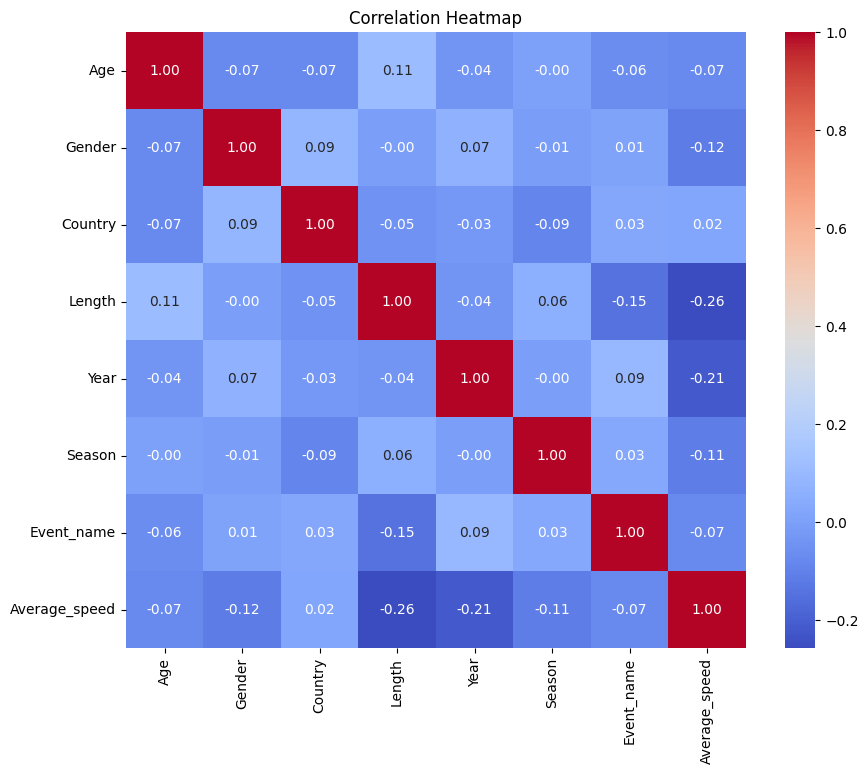

                            OLS Regression Results                            
Dep. Variable:          Average_speed   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                 7.328e+04
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:45:37   Log-Likelihood:            -6.2630e+06
No. Observations:             2925730   AIC:                         1.253e+07
Df Residuals:                 2925722   BIC:                         1.253e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    170.5964      0.411    415.348      0.0

'\n# Plot the actual vs. predicted speeds against each other\nplt.figure(figsize=(10, 6))\nsns.regplot(x=\'Average_speed\', y=\'Predicted_speed\', data=ultra_marathon_selected, scatter_kws={\'s\': 10}, line_kws={"color": "red"})\nplt.xlabel(\'Actual Average Speed\')\nplt.ylabel(\'Predicted Average Speed\')\nplt.title(\'Actual vs Predicted Average Speed\')\nplt.show()\n'

In [3]:
# The linear regression

from sklearn.preprocessing import LabelEncoder

ultra_marathon_encoded = ultra_marathon.copy()
ultra_marathon_encoded.dropna(subset=['Year', 'Finishers', 'Birth', 'Age', 'Average_speed', 'Id'], inplace=True)

country_encoder = LabelEncoder()
event_encoder = LabelEncoder()

# Extract the month from the Dates column (the object is a list of this type  [2018-01-06 00:00:00])
ultra_marathon_encoded['Season'] = ultra_marathon_encoded['Dates'].apply(lambda x: x[0].month if isinstance(x, list) else None)
# remove the null values
ultra_marathon_encoded = ultra_marathon_encoded.dropna(subset=['Season'])
# Conver it to int
ultra_marathon_encoded['Season'] = ultra_marathon_encoded['Season'].astype(int)

# Map the season to the month
season_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
ultra_marathon_encoded['Season'] = ultra_marathon_encoded['Season'].map(season_map)

# Print the percentage of each season
print(ultra_marathon_encoded['Season'].value_counts(normalize=True) * 100)


# Since the countries aren't of the appropriate datatype (they're str), we encode each country to a Country_ID
# Drop the values of average speed that are above 21, and hot encode (map) each country to an ID
ultra_marathon_encoded = ultra_marathon_encoded[ultra_marathon_encoded['Average_speed'] <= 21]
ultra_marathon_encoded['Country_ID'] = country_encoder.fit_transform(ultra_marathon_encoded['Country'])

# Drop any events prior to 1972, and hot encode (map) the events as well to be able to perform the regression
ultra_marathon_encoded = ultra_marathon_encoded[ultra_marathon_encoded['Year'] >= 1972]
ultra_marathon_encoded['Event_name'] = event_encoder.fit_transform(ultra_marathon_encoded['Event_name'])

# Also encode each race category/type to an index from 1
lengths = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']
length_index = {length: i for i, length in enumerate(lengths, start=1)}

# The actual mapping
def map_length_to_index(given_string):
    if pd.isna(given_string):
        return np.nan
    else:
        for length in lengths:
            if length in given_string:
                return length_index[length]
        return np.nan

ultra_marathon_encoded['Length_Index'] = ultra_marathon_encoded['Length'].apply(map_length_to_index)

selected_columns = ['Age', 'Gender', 'Country_ID', 'Length_Index', 'Year', 'Season', 'Event_name', 'Average_speed']
ultra_marathon_selected = ultra_marathon_encoded[selected_columns]
ultra_marathon_selected.rename(columns={'Age': 'Age', 'Gender': 'Gender', 'Country_ID': 'Country', 'Length_Index': 'Length'}, inplace=True)

# Compute the correlation between each independent variable (covariate) and the target variable (average speed)
correlation_with_avg_speed = ultra_marathon_selected.corr()

# Plotting the heatmap/correlation matrix 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_avg_speed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Define the formula for linear regression
formula = 'Average_speed ~ Age + Gender + Country + Season + Year + Event_name + Length'

# Fit the linear regression model
model = smf.ols(formula=formula, data=ultra_marathon_selected).fit()

# Print the summary of the regression model
print(model.summary())

# Now predicting values in order to plot
# ultra_marathon_selected['Predicted_speed'] = model.predict(ultra_marathon_selected)

# Plotting

'''
# Plot the actual vs. predicted speeds against each other
plt.figure(figsize=(10, 6))
sns.regplot(x='Average_speed', y='Predicted_speed', data=ultra_marathon_selected, scatter_kws={'s': 10}, line_kws={"color": "red"})
plt.xlabel('Actual Average Speed')
plt.ylabel('Predicted Average Speed')
plt.title('Actual vs Predicted Average Speed')
plt.show()
'''

In [4]:
# ------------------------------ TOP 6 ----------------------------------
# Filtering the dataframe by the top 6 most popular events only, as specified from 2 cells above-ish
ultra_marathon_selected_2 = ultra_marathon_selected.copy()
top_6_events = [
    '100 km Lauf Biel (SUI)', 
    'Two Oceans Marathon - 50km Split (RSA)', 
    '100 km del Passatore, Firenze-Faenza (ITA)', 
    'Les 100 km de Millau (FRA)', 
    'Yukihashi to Beppu 100 km (JPN)',
    "Om Die Dam 50km (RSA)"
]
top_6_events_encoded = event_encoder.transform(top_6_events)
ultra_marathon_filtered_top_6 = ultra_marathon_selected_2[ultra_marathon_selected_2['Event_name'].isin(top_6_events_encoded)]

# Running the regression again, now only for these top 5 events
formula_filtered = 'Average_speed ~ Age + Gender + Country + Season + Year + Length'
model_filtered = smf.ols(formula=formula_filtered, data=ultra_marathon_filtered_top_6).fit()
r_squared_top_6 = model_filtered.rsquared
print("R-squared (Filtered by Top 5 Model):", r_squared_top_6)


# ------------------------------ TOP 20 ----------------------------------
'''
# Now running the regression on the top 20 events
ultra_marathon_selected_3 = ultra_marathon_selected.copy()
top_20_events = [
    "100 km Lauf Biel (SUI)",
    "Two Oceans Marathon - 50km Split (RSA)",
    "100 km del Passatore, Firenze-Faenza (ITA)",
    "Les 100 km de Millau (FRA)",
    "Yukihashi to Beppu 100 km (JPN)",
    "Om Die Dam 50km (RSA)",
    "JFK 50 Mile (USA)",
    "Lake Saroma 100 Km Ultramarathon (JPN)",
    "Oxfam Trailwalker Hong Kong (HKG)",
    "River Shimanto 100km (JPN)",
    "American River 50 Mile Endurance Run (USA)",
    "Loskop Ultra Marathon 50km (RSA)",
    "Way Too Cool 50K Endurance Run (USA)",
    "Yatsugatake Nobeyama 100 km (JPN)",
    "100 km Lauf Unna (GER)",
    "Tango 100 km Ultramarathon (JPN)",
    "Hong Kong 100 Ultra Trail Race (HKG)",
    "Western States 100 Mile Endurance Run (USA)",
    "50 km di Romagna (ITA)",
    "100 km du Périgord Noir, Belves (FRA)"
]
top_20_events_encoded = label_encoder.transform(top_20_events)
ultra_marathon_filtered_top_20 = ultra_marathon_selected_3[ultra_marathon_selected_3['Event_name'].isin(top_20_events_encoded)]

# Running the regression again, now only for the top 20 events
formula_filtered_top_20 = 'Average_speed ~ Age + Gender + Country + Season + Year + Length'
model_filtered_top_20 = smf.ols(formula=formula_filtered_top_20, data=ultra_marathon_filtered_top_20).fit()
r_squared_top_20 = model_filtered_top_20.rsquared
print("R-squared (Filtered by Top 20 Model):", r_squared_top_20)
'''

R-squared (Filtered by Top 5 Model): 0.5060935760444545


'\n# Now running the regression on the top 20 events\nultra_marathon_selected_3 = ultra_marathon_selected.copy()\ntop_20_events = [\n    "100 km Lauf Biel (SUI)",\n    "Two Oceans Marathon - 50km Split (RSA)",\n    "100 km del Passatore, Firenze-Faenza (ITA)",\n    "Les 100 km de Millau (FRA)",\n    "Yukihashi to Beppu 100 km (JPN)",\n    "Om Die Dam 50km (RSA)",\n    "JFK 50 Mile (USA)",\n    "Lake Saroma 100 Km Ultramarathon (JPN)",\n    "Oxfam Trailwalker Hong Kong (HKG)",\n    "River Shimanto 100km (JPN)",\n    "American River 50 Mile Endurance Run (USA)",\n    "Loskop Ultra Marathon 50km (RSA)",\n    "Way Too Cool 50K Endurance Run (USA)",\n    "Yatsugatake Nobeyama 100 km (JPN)",\n    "100 km Lauf Unna (GER)",\n    "Tango 100 km Ultramarathon (JPN)",\n    "Hong Kong 100 Ultra Trail Race (HKG)",\n    "Western States 100 Mile Endurance Run (USA)",\n    "50 km di Romagna (ITA)",\n    "100 km du Périgord Noir, Belves (FRA)"\n]\ntop_20_events_encoded = label_encoder.transform(top_20_e

In [ ]:
# Have there been any significant shifts in regional participation patterns?
import pycountry_convert as pc

def country_to_continent(country_iso):
    try:
        continent_code = pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(country_iso))
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return np.nan


# erased_p = ultra_marathon[ultra_marathon['Year'] < 1972].shape[0]/ultra_marathon[ultra_marathon['Year'] >= 1972].shape[0]
# print("We only take into account the values for the last 50 years, erasing ", round(erased_p*100, 3), "% of the data")

# Create appropriate dataset
ultra_marathon_region = ultra_marathon.copy()
ultra_marathon_region['Continent'] = ultra_marathon_region['Country'].apply(country_to_continent)
ultra_marathon_region = ultra_marathon_region[ultra_marathon_region['Year'] >= 1900]


# Get participants per year & continent (one row per data)
participants_d = ultra_marathon_region.groupby(['Year', 'Continent']).size().reset_index(name='Participants')
# Get participants per year & continent (one row per year)
participants_y = participants_d.pivot(index='Year', columns='Continent', values='Participants')
participants_y.fillna(0, inplace=True)
participants_perc = participants_y.div(participants_y.sum(axis=1), axis=0) * 100
participants_perc_50 = participants_perc[participants_perc.index >= 1972]



# ____________________________Plotting__________________________________________


# Plot the stacked area chart for percentage distribution since 1972
sns.set_palette("colorblind")
plt.figure(figsize=(14, 7))
participants_perc_50.plot(kind='area', stacked=True, legend=False)
# Plot characteristics
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(np.arange(participants_perc_50.index.min(), participants_perc_50.index.max() + 1, 10))
plt.title('Stacked Relative Proportion of Participants by Continent on The Last 50 Years')
plt.xlabel('Year')
plt.ylabel('Participants (%)')

plt.show()
